# Data treatment and Neural Network Training using IPMA data
João Oliveira and Edgar Mendes

In [1]:
#-----------------------Imports

#Data request libraries
import requests
import json

#Mathematics libraries
import matplotlib.pyplot as plt
import pydot
import ipyplot 
import numpy as np

#Time variables libraries
from datetime import datetime, timedelta
import time
import datetime
import pytz
from datetime import date
from datetime import datetime

#File management libraries
import io
from io import BytesIO
import os
import shutil
from PIL import Image, ImageDraw

#Progress bar libraries
from ipywidgets import IntProgress
from IPython.display import display

#Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn import svm
import tensorflow as tf
import tensorflow.keras as keras
from keras import callbacks
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization
from keras.utils.vis_utils import plot_model

#-----------------------Constantes

#Recorte para cada distrito
boxVianaDoCastelo = (570, 428, 770, 628)
boxLeiria = (574, 902, 774, 1102)
boxAveiro = (603, 687, 803, 887)
boxBeja =  (735, 1546, 935, 1746)
boxBraga =  (645, 463, 845, 663)
boxBraganca = (953, 401, 1153, 601)
boxCasteloBranco = (817, 886, 1017, 1086)
boxPortalegre = (829, 1012, 1029, 1212)
boxPorto = (611, 562, 811, 762)
boxSantarem = (597, 1026, 797, 1226)
boxCoimbra = (645, 792, 845, 992)
boxEvora = (740, 1183, 940, 1383)
boxFaro = (736, 1546, 936, 1746)
boxGuarda = (859, 712, 1059, 912)
boxLisboa = (513, 1149, 713, 1349)
boxSetubal = (559, 1193, 759, 1393)
boxVilaReal = (770, 527, 970, 727)
boxViseu = (740, 682, 940, 882)

#Dados das estações
idVianaDoCastelo, idLeiria, idAveiro, idBeja, idBraga, idBraganca, idCasteloBranco, idPortalegre, idPorto, idSantarem, idCoimbra, idEvora, idFaro, idGuarda, idLisboa, idSetubal, idVilaReal, idViseu = 1240610, 1210718, 1210702, 1200562, 6212124, 1200575, 1200570, 1200571, 1240903, 1210734, 1210707, 1200558, 1200554, 1210683, 7240919, 1210770, 1240566, 1240675
ids = np.array([1240610, 1210718, 1210702, 1200562, 6212124, 1200575, 1200570, 1200571, 1240903, 1210734, 1210707, 1200558, 1200554, 1210683, 7240919, 1210770, 1240566, 1240675])
station_box_dict = {idVianaDoCastelo: boxVianaDoCastelo, idLeiria: boxLeiria, idAveiro: boxAveiro, idBeja: boxBeja, idBraga: boxBraga, idBraganca: boxBraganca, idCasteloBranco: boxCasteloBranco, idPortalegre: boxPortalegre, idPorto: boxPorto, idSantarem: boxSantarem, idCoimbra: boxCoimbra, idEvora: boxEvora, idFaro: boxFaro, idGuarda: boxGuarda, idLisboa: boxLisboa, idSetubal: boxSetubal, idVilaReal: boxVilaReal, idViseu: boxViseu}

#-----------------------Funções

#Data request functions

def get_data(url):
    response = requests.get(f"{url}")
    if response.status_code == 200:
        #print("Sucessfully fetched the data!") 
        return response.json() #https://www.educative.io/answers/how-to-make-api-calls-in-python
    else:
        print(f"Hello there, there's a {response.status_code} error with your request.")
        
def normalize_precipitation_value(precipitation_value):
    return int(round((precipitation_value/240)*100,0)) #o valor normalizado ta a ser arredondado pq as pastas sao de valores inteiros. https://www.ipma.pt/pt/oclima/extremos.clima/ Vou usar o valor máximo aqui como referencia

def list_dataset_folders():
    folders = []
    folder_path = os.getcwd()
    for name in os.listdir(folder_path):
        if os.path.isdir(os.path.join(folder_path, name)):
            if name.endswith("dataset"):
                folders.append(name)
    return folders

def remove_black_pixels(image):
    # Convert the image to RGBA mode (if it's not already in RGBA mode)
    image = image.convert("RGBA")
    # Get the pixel data as a list of tuples
    pixels = list(image.getdata())
    # Replace every black pixel with transparent
    new_pixels = []
    for pixel in pixels:
        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
            new_pixels.append((0, 0, 0, 0))
        else:
            new_pixels.append(pixel)

    # Create a new image with the same size and mode as the original image
    new_image = Image.new(image.mode, image.size)
    # Update the new image with the new pixel data
    new_image.putdata(new_pixels)
    # Return the new image
    return new_image

#Manage dictionaries and arrays

def create_zero_dict(input_dict):
    zero_dict = {key: 0 for key in input_dict} #cria um dicionario onde as chaves são as mesmas do dicionario que recebeu mas o value é 0 em todas
    return zero_dict

def get_dict_keys(input_dict):
    keys_array = list(input_dict.keys())
    return keys_array

def dict_to_array1D(input_dict):
    # Create an empty list to hold the values
    output_array = np.empty(0)
    # Loop over each key-value pair in the dictionary
    for date_dict in input_dict.values():
        for value in date_dict.values():
            # Append the value to the output array
            output_array = np.append(output_array,value)
    # Return the output array
    return output_array

def array2D_to_array1D(array_2D):
    array1D = np.ravel(array_2D)
    return array1D

def array1D_to_array2D(array_1D):
    array2D = np.empty(0)
    array2D = np.reshape(array_1D, (-1, 1))
    return array2D

#Dataset labels array management

def count_how_many_occurences_of_each_value(arr):
    arr = array2D_to_array1D(arr)
    counts = {}
    for num in arr:
        if num in counts:
            counts[num] += 1
        else:
            counts[num] = 1
    return counts

def get_objective_hour():
    # get current time
    now = datetime.datetime.now()
    # extract current hour from the current time
    current_hour = now.hour
    objective_hour = current_hour - 2
    objective_hour = str(current_hour) + ':00'
    return objective_hour

def extract_hour_data(json_obj,objective_hour):    
    hour_data = []
    for date in json_obj:
        if objective_hour in json_obj[date]:
            hour_data.append(json_obj[date][objective_hour])
    return hour_data

#Manage images

def shift_image_left(image_path, shift_value):
    # Open the image
    image = Image.open(image_path)
    
    # Create a new image with the updated width
    new_image = Image.new(image.mode, (image.width, image.height))

    # Copy the original image onto the new image, shifted to the left
    new_image.paste(image, (-shift_value, 0))

    # Get the last column of the original image
    last_column = image.crop((image.width - 1, 0, image.width, image.height))

    # Paste the last column into the new columns
    for x in range(image.width - shift_value, image.width):
        new_image.paste(last_column, (x, 0, x + 1, image.height))

    # Return the shifted and filled image
    return new_image

def shift_image_right(image_path, shift_value):
    # Open the image
    image = Image.open(image_path)
        
    # Create a new image with the updated width
    new_image = Image.new(image.mode, (image.width, image.height))

    # Copy the original image onto the new image, shifted to the right
    new_image.paste(image, (shift_value, 0))

    # Get the first column of the original image
    first_column = image.crop((0, 0, 1, image.height))

    # Paste the first column into the new columns
    for x in range(shift_value):
        new_image.paste(first_column, (x, 0, x + 1, image.height))

    # Return the shifted and filled image
    return new_image

def rotate_image(image_path, angle):
    # Open the image
    image = Image.open(image_path)

    # Rotate the image
    rotated_image = image.rotate(angle, expand=True)

    # Create a new image with RGBA mode and transparent background
    new_image = Image.new("RGBA", rotated_image.size, (0, 0, 0, 0))

    # Paste the rotated image onto the new image
    new_image.paste(rotated_image, (0, 0), rotated_image)

    #Resize image to 200x200
    new_image = new_image.resize((200,200))

    # Return the rotated and filled image
    return new_image

def flip_image_horizontally(image_path):
    # Open the image
    image = Image.open(image_path)

    # Flip the image horizontally
    flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT)

    # Return the flipped image
    return flipped_image

def flip_image_vertically(image_path):
    # Open the image
    image = Image.open(image_path)

    # Flip the image vertically
    flipped_image = image.transpose(Image.FLIP_TOP_BOTTOM)

    # Return the flipped image
    return flipped_image

In [2]:
DADOS_ULTIMAS_3_HORAS = "https://api.ipma.pt/open-data/observation/meteorology/stations/obs-surface.geojson" #por exemplo se forem 9PM tem os dados entre 5PM e 7PM de hora a hora para todas as estações
local_tz = pytz.timezone('Europe/Lisbon') #Define o fuso horário local

def get_images_and_data_from_ipma():
    
    data = get_data(DADOS_ULTIMAS_3_HORAS)
    specific_datasets = list_dataset_folders()
    # Faz a requisição à apiEstacoes e à apiMeteo para obter as informações meteorológicas 
    final_result = {}
    for feature in data['features']:
        f.value+=1
        if feature['properties']['idEstacao']  in ids:
            station_data = feature['properties']
            id_estacao = station_data['idEstacao']
            # Converte a hora da estação para o fuso horário local
            date_time_utc = datetime.fromisoformat(station_data['time'])
            date_time = datetime.fromisoformat(station_data['time']).replace(tzinfo=pytz.utc).astimezone(local_tz)
            date_str, hour_str = date_time.strftime('%Y-%m-%d %H:%M').split()
            precipitation = station_data['precAcumulada']

            if date_str not in final_result:
                final_result[date_str] = {hour_str: precipitation}
            else:
                final_result[date_str][hour_str] = normalize_precipitation_value(max(0, precipitation))

            url_image = f"https://www.ipma.pt/resources.www/transf/radar/por/pcr-{date_time_utc.strftime('%Y-%m-%d')}T{date_time_utc.strftime('%H%M')}.png"
            response = requests.get(url_image)
            image_data = io.BytesIO(response.content)
            image = Image.open(image_data)
            #print(f"{url_image} ({hour_str}h)")
                    
            # remover os pixeis pretos 
            image = remove_black_pixels(image)

            # Cor-te da imagem
            region = image.crop(station_box_dict[id_estacao])
            for specific_dataset in specific_datasets:

                # verifica se a pasta id_estacao existe e cria se não existir
                if not os.path.exists(f"{specific_dataset}/images/{id_estacao}"):
                    os.makedirs(f"{specific_dataset}/images/{id_estacao}")

                # verifica se a pasta date_str existe e cria se não existir
                if not os.path.exists(f"{specific_dataset}/images/{id_estacao}/{date_str}"):
                    os.makedirs(f"{specific_dataset}/images/{id_estacao}/{date_str}")

                elif specific_dataset == 'dataset':
                    region.save(f"{specific_dataset}/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png")
                    original_image_path = f"dataset/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png"

                elif specific_dataset == 'left_20px_shifted_dataset':        
                    shift_image_left(original_image_path, 20).save(f"{specific_dataset}/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png")
                    left_shifted_image_path = f"left_20px_shifted_dataset/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png"

                elif specific_dataset == 'right_20px_shifted_dataset':        
                    shift_image_right(original_image_path, 20).save(f"{specific_dataset}/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png")
                    right_shifted_image_path = f"right_20px_shifted_dataset/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png"

                elif specific_dataset == 'rotated_1degree__left_20px_shifted_dataset':
                    rotate_image(left_shifted_image_path, 1).save(f"{specific_dataset}/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png")

                elif specific_dataset == 'rotated_1degree__right_20px_shifted_dataset':
                    rotate_image(right_shifted_image_path, 1).save(f"{specific_dataset}/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png")

                elif specific_dataset == 'rotated_1degree_dataset':
                    rotate_image(original_image_path, 1).save(f"{specific_dataset}/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png")

                # Verifica se o arquivo JSON para esta estação já existe, se não, cria o arquivo
                filename = f"{specific_dataset}/precipitation/{id_estacao}.json"
                if not os.path.isfile(filename):
                    with open(filename, 'w') as file:
                        json.dump({}, file)

                # Carrega o conteúdo do arquivo JSON para a variável "precipitation_data"
                with open(filename, 'r') as file:
                    precipitation_data = json.load(file)

                # Adiciona as informações meteorológicas ao arquivo JSON
                for date in final_result:
                    if date not in precipitation_data:
                        precipitation_data[date] = final_result[date]
                    else:
                        precipitation_data[date].update(final_result[date])

                # Escreve o conteúdo atualizado no arquivo JSON
                with open(filename, 'w') as file:
                    json.dump(precipitation_data, file, indent=4)
    print("Dados atualizados com sucesso!")

In [3]:
progress_bar_length = 495
f = IntProgress(min=0, max=progress_bar_length) # instantiate the bar
display(f) # display the bar
get_images_and_data_from_ipma()

IntProgress(value=0, max=495)

Dados atualizados com sucesso!


dataset
(200, 200)


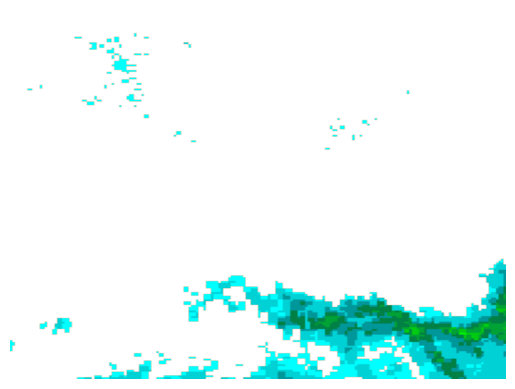

left_20px_shifted_dataset
(200, 200)


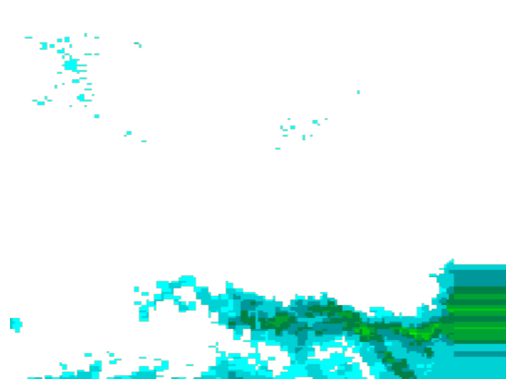

right_20px_shifted_dataset
(200, 200)


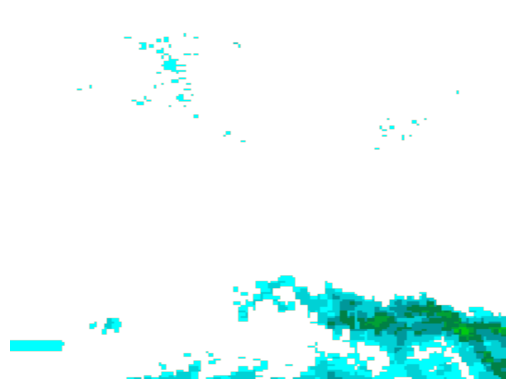

rotated_1degree_dataset
(200, 200)


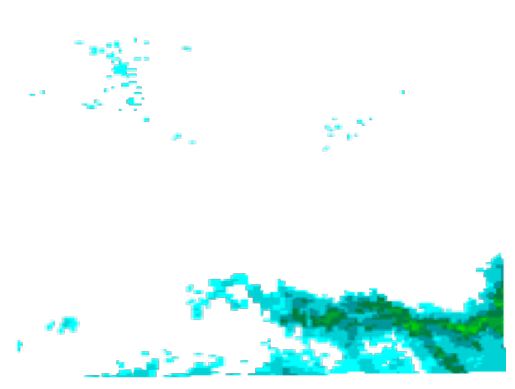

rotated_1degree__left_20px_shifted_dataset
(200, 200)


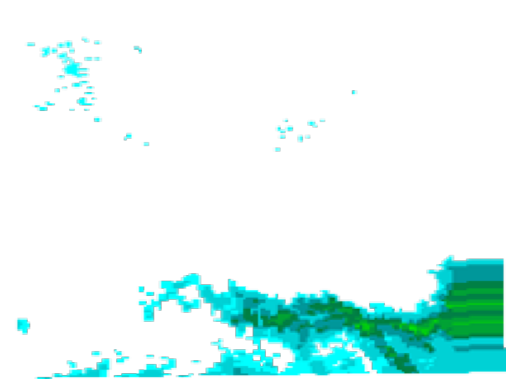

rotated_1degree__right_20px_shifted_dataset
(200, 200)


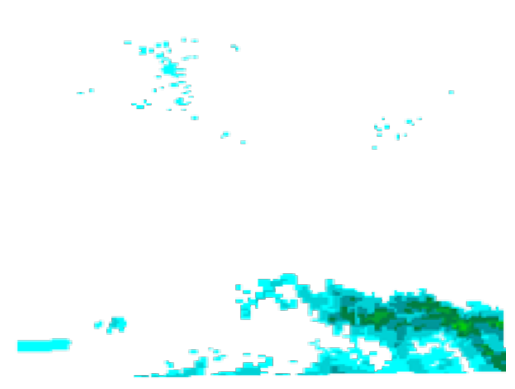

In [14]:
datasets = list_dataset_folders()
#print the first image of each dataset
for dataset in datasets:
    image_path = dataset + '/images/1200554/2023-04-07/2023-04-07T2100.png'
    print(dataset)
    

    # Open the image using PIL
    image = Image.open(image_path)

    #print image on image_path and print its size
    print(image.size)

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Add a frame around the image
    ax.imshow(image, aspect='auto', extent=(0, image.width, 0, image.height))
    ax.axis('off')

    # Display the image with the frame
    plt.show()

# Data treatment

In [15]:
specific_datasets = list_dataset_folders()
image_size = 200
flag = False
data_array = np.empty(0)
images_array = np.empty((0, image_size, image_size, 4))


#objective_hour = get_objective_hour()
objective_hour = '12:00'
images_end_with ='T'+ objective_hour[:2]+'00.png'

for dataset in specific_datasets:
    for stationJson in ids:
        currentDir = dataset+'/precipitation/'+str(stationJson)+'.json'
        with open(currentDir) as f:
            # Load the JSON data
            data = json.load(f)
        f.close()
        current_data_array = np.empty(0)
        current_data_array = extract_hour_data(data,objective_hour)
        data_array = np.concatenate((data_array, current_data_array))
        if not flag:
            flag = True
            progress_bar_length = len(specific_datasets)*len(ids)*len(data_array)
            progress_bar = IntProgress(min=0, max=progress_bar_length) # instantiate the bar
            display(progress_bar) # display the bar
    for stationFolder in ids:
        images_folder_path = dataset+'/images/'+str(stationFolder)+'/'
        # Get a list of all the files in the current folder
        file_list = os.listdir(images_folder_path)
        # Filter the list to only include folders files
        days_folders_list = [file for file in file_list if os.path.isdir(os.path.join(images_folder_path, file))]
        for day_folder in days_folders_list:
            current_path = images_folder_path + day_folder
            #Get a list of all files in the folder 
            files_list = os.listdir(current_path)
            # Filter the list to only include images files
            image_list = [file for file in files_list if file.endswith(images_end_with)]
            for i in range(len(image_list)):
                image_path = os.path.join(current_path, image_list[i])
                #print(image_path)
                image = Image.open(image_path)
                img_np = np.array(image)
                images_array = np.append(images_array,[img_np], axis=0) #NAO TIRAR PARENTESIS RETOS!!!!!!!!!!!!!!
                progress_bar.value += 1
                
data_array = array1D_to_array2D(data_array)


new_data_array = np.empty(0)
new_images_array = np.empty((0, image_size, image_size, 4))

how_many_of_each_value = count_how_many_occurences_of_each_value(array2D_to_array1D(data_array))
smallest_value = min(how_many_of_each_value.values())
dict_counter = create_zero_dict(how_many_of_each_value)

how_many_different_values = len(how_many_of_each_value) * smallest_value

f = IntProgress(min=0, max=how_many_different_values) # instantiate the bar
display(f) # display the bar

for index in range(len(data_array)):
    if len(images_array) == how_many_different_values:
        break
    if dict_counter[data_array[index][0]] < smallest_value:
        dict_counter[data_array[index][0]]+=1
        new_data_array = np.append(new_data_array,data_array[index])
        new_images_array = np.append(new_images_array,[images_array[index]], axis=0)
        f.value+=1
new_data_array = array1D_to_array2D(new_data_array)

print(f"Total of images: {len(images_array)} \n How manny of each class: {np.unique(data_array, return_counts=True)} \n\n Selecting images... \n\n Number of images after selection: {len(new_data_array)} \n How manny of each class after selection: {np.unique(new_data_array, return_counts=True)}")

IntProgress(value=0, max=756)

Number of images: 756



#  Model Training

In [61]:
perm = np.random.permutation(len(new_data_array))
new_images_array = new_images_array[perm]
new_data_array = new_data_array[perm]

train_images, val_images, train_values, val_values = train_test_split(new_images_array, new_data_array, test_size=0.2, random_state=10)

train_images = tf.keras.utils.normalize(train_images, axis=1)
val_images = tf.keras.utils.normalize(val_images, axis=1)

print("How many of each value in train:")
print(count_how_many_occurences_of_each_value(train_values))
print("How many of each value in validation:")
print(count_how_many_occurences_of_each_value(val_values))


{1.0: 88, 0.0: 84}
{1.0: 20, 0.0: 24}


In [18]:
#Valores da rede neuronal
 
n_channels = 4 
n_classes = 100 
n_neuronios = 16
filter_size = 3 
max_pool_size = (2,2) 
n_epochs = 100 
n_strides = 1
dropout_value = 0.25 

model = Sequential()
model.add(Conv2D(n_neuronios, max_pool_size, activation='relu', input_shape=(image_size, image_size, n_channels)))
model.add(Conv2D(n_neuronios, filter_size, strides=n_strides, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_value))
model.add(MaxPooling2D(pool_size=max_pool_size))
model.add(BatchNormalization())
model.add(Conv2D(n_neuronios*2, filter_size, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(n_neuronios*4, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_value))
model.add(Dense(n_classes, activation='softmax'))

#model.summary()
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_draw.png')

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=False, verbose=1, start_from_epoch=30) #Stop training when a monitored metric has stopped improving
model_checkpoint = callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=0, mode='max', save_weights_only=True) #Callback to save the Keras model or model weights at some frequency
#reduce_lr_on_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_delta=0.01, cooldown=0, min_lr=0) #Reduce learning rate when a metric has stopped improving
terminate_on_nan = callbacks.TerminateOnNaN() #Callback that terminates training when a NaN (Not-a-number) loss is encountered

#load best weights
try:
    model.load_weights('best_model.h5')
    print("Weights loaded")
finally:
    #train the model with the callbacks
    history = model.fit(train_images, train_values, epochs= n_epochs, validation_data=(val_images, val_values), callbacks=[early_stopping, model_checkpoint, terminate_on_nan], verbose=1)

Weights loaded


NameError: name 'train_images' is not defined

In [4]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()

    plt.plot(history.history['lr'])
    plt.title('Learning Rate')
    plt.ylabel('learning rate')
    plt.xlabel('epoch')
    plt.legend(['lr'])
    plt.show()

plot_history(history)

NameError: name 'history' is not defined